# Projeto-ICD: Análise de dados sobre sentimentos e reações do público nas premiações do Oscar

**Integrantes:** Lucas Marinho, Lucas Nery, Giulle e Gustavo

## 1. Introdução

**Motivação:** 
As premiações do Oscar geram enorme repercussão nas redes sociais.

**Objetivos:**
- Avaliar sentimentos (positivo, neutro, negativo) dos comentários.
- Investigar relação entre sentimentos e métricas como upvotes e profundidade.

## 2. Dados Usados

### 2.1 Origem e Coleta dos Dados

- **Fonte**: Reddit, post anual do subreddit r/Oscars  
- **API utilizada**: PRAW (Python Reddit API Wrapper)  
- **Procedimento**:  
  1. Acessamos o post principal do Oscar no r/Oscars via PRAW, recuperando título, texto, autor e metadados do post.  
  2. Iteramos sobre todos os comentários (incluindo aninhamentos), armazenando texto, autor, votos e profundidade.  
  3. Para cada comentário, aplicamos VADER para classificação de sentimento (positivo, neutro ou negativo).

### 2.2 Formato e Tamanho dos Arquivos

| Arquivo                                 | Linhas | Colunas |
|-----------------------------------------|-------:|--------:|
| post_coletado.csv                       |      1 |        9 |
| comentarios_coletados.csv               | 12 811 |        4 |
| post_coletado_br.csv                    |      1 |        9 |
| comentários_coletados_br_final.csv      |  2 498 |        6 |

- **post_coletado.csv**: post onde os comentários foram coletados (todos os idiomas).
- **comentarios_coletados.csv**: amostra geral de comentários (todos os idiomas).
- **post_coletado_br.csv**: post onde os comentários foram coletados (Brasil).
- **comentários_coletados_br_final.csv**: filtragem apenas para comentários em português (Brasil), com colunas extras de autor e data.


### 2.3 Descrição das Colunas (comentários)

| Coluna      | Tipo    | Descrição                                                         |
|-------------|---------|-------------------------------------------------------------------|
| comentário  | object  | Texto completo do comentário                                      |
| sentimento  | object  | Rótulo de sentimento (positivo / neutro / negativo), via VADER    |
| upvotes     | int64   | Quantidade de votos positivos recebidos                           |
| depth       | int64   | Profundidade na thread (0 = comentário raiz, 1 = resposta, etc.)  |
| autor       | object  | Nome de usuário do autor (presente somente em _br_final_)         |
| data        | object  | Data e hora da publicação (presente somente em _br_final_)        |

### 2.4 Importação e Carregamento

In [28]:
import string 
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import unicodedata     

# Carregando os datasets de comentários
df_all = pd.read_csv('data/comentarios_coletados.csv', encoding='utf-8')
df_br  = pd.read_csv('data/comentários_coletados_br_final.csv', encoding='utf-8')

### 2.5 Verificação de tipos

In [2]:
print("### comentarios_coletados.csv ###")
df_all.info()

print("\n### comentários_coletados_br_final.csv ###")
df_br.info()

### comentarios_coletados.csv ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentário  12811 non-null  object
 1   sentimento  12811 non-null  object
 2   upvotes     12811 non-null  int64 
 3   depth       12811 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 400.5+ KB

### comentários_coletados_br_final.csv ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentário  2497 non-null   object
 1   sentimento  2498 non-null   object
 2   upvotes     2498 non-null   int64 
 3   depth       2498 non-null   int64 
 4   autor       2430 non-null   object
 5   data        2498 non-null   object
dtypes: int64(2), object(4)
memory usage: 117.2+ KB


### 2.6 Primeira Visualização

In [3]:
print("— Primeiras 5 linhas de comentarios_coletados.csv —")
display(df_all.head())

print("\n— Primeiras 5 linhas de comentários_coletados_br_final.csv —")
display(df_br.head())

— Primeiras 5 linhas de comentarios_coletados.csv —


,comentário,sentimento,upvotes,depth
0,"Congrats on the upcoming sex, Kieran",positivo,93,0
1,"Ohh, he's going in!",neutro,4,1
2,Fhritp,neutro,2,1
3,First woman of Dominican origin to win an Osca...,positivo,95,0
4,It’s coming 😂,neutro,3,1



— Primeiras 5 linhas de comentários_coletados_br_final.csv —


,comentário,sentimento,upvotes,depth,autor,data
0,https://preview.redd.it/srbaoego7eme1.jpeg?wid...,neutro,61,0,sorryperiferia,2025-03-03 00:20:27
1,And the bags they pull...,neutro,13,1,NorthHealthy4921,2025-03-03 00:21:43
2,So happy for you Brazilians!!!,positivo,57,0,BrightNeonGirl,2025-03-03 00:11:49
3,"Thank you, kind foreigner! AAAAAAH HOW HAPPY ...",positivo,6,1,Emb_IvanAwfulitch,2025-03-03 00:13:39
4,THANK YOU MY FELLOW GRINGO!!!!!,positivo,7,1,emperorzura,2025-03-03 00:14:19


### 2.7 Exploração Inicial

Nesta etapa, vamos rapidamente:
- Verificar distribuição de sentimentos  
- Obter estatísticas de upvotes e profundidade  
- Contagem de duplicatas e valores faltantes em `autor` (BR)

### 2.7.1 Distribuição de sentimentos

,Conjunto,# comentários,% positivos,% neutros,% negativos
0,Geral,10898,43.05,35.23,21.72
1,BR,2163,19.97,69.02,11.00


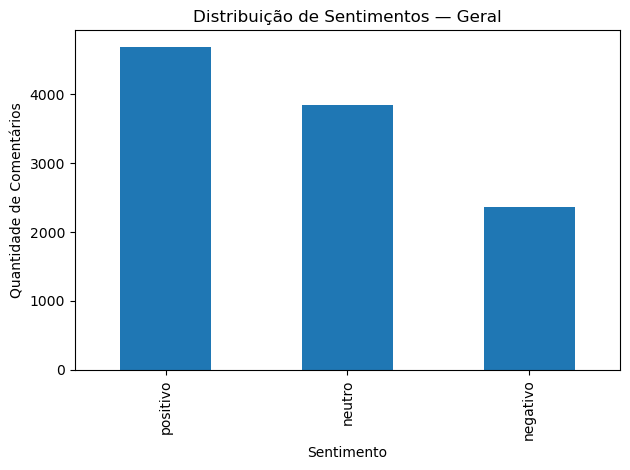

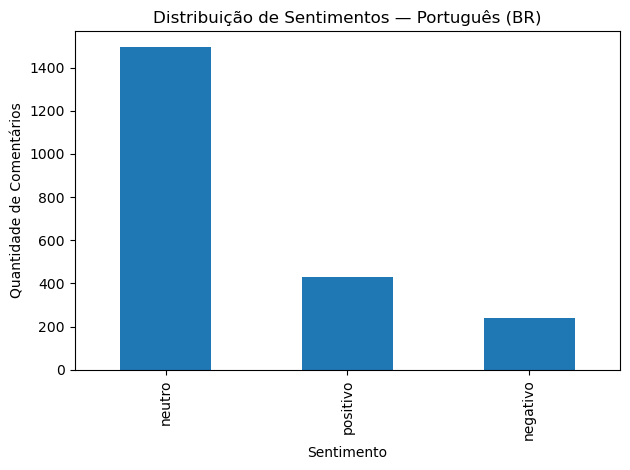

In [26]:
# Função que monta a linha de resumo
def resumo_sentimentos(df, nome):
    total = len(df)
    pct = df['sentimento'].value_counts(normalize=True) * 100
    return {
        'Conjunto': nome,
        '# comentários': total,
        '% positivos': round(pct.get('positivo', 0), 2),
        '% neutros':   round(pct.get('neutro',   0), 2),
        '% negativos': round(pct.get('negativo', 0), 2),
    }

# Montar DataFrame-resumo
summary = pd.DataFrame([
    resumo_sentimentos(df_all, 'Geral'),
    resumo_sentimentos(df_br,  'BR')
])

# Exibir a tabela
display(summary)

# Contar sentimentos para os gráficos
sent_all = df_all['sentimento'].value_counts()
sent_br = df_br['sentimento'].value_counts()

# Gráficos de distribuição de sentimentos
plt.figure()
sent_all.plot(kind='bar')
plt.title('Distribuição de Sentimentos — Geral')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

plt.figure()
sent_br.plot(kind='bar')
plt.title('Distribuição de Sentimentos — Português (BR)')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

### 2.7.2 Estatísticas de upvotes e depth

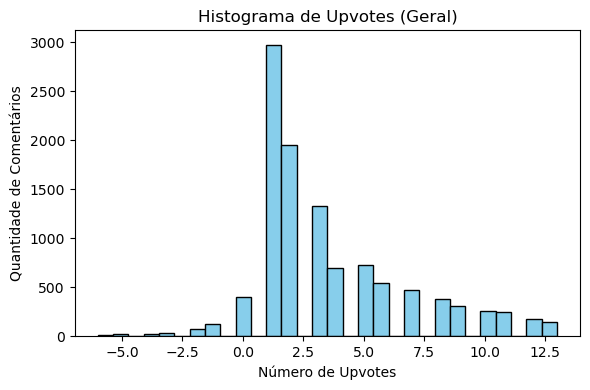

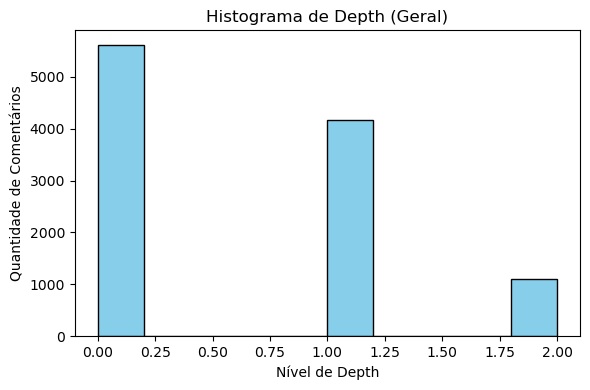

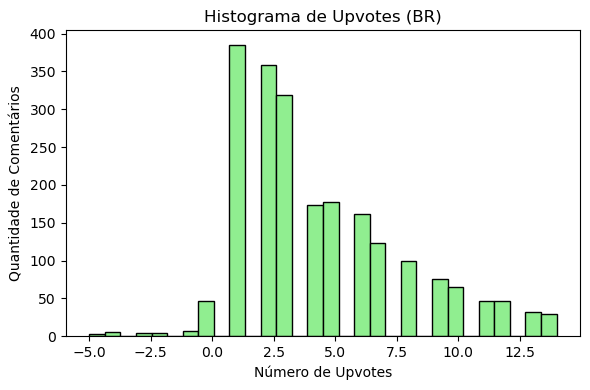

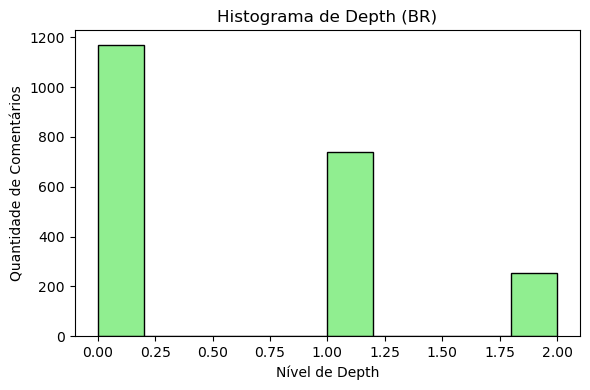

In [27]:
# Histograma de UPVOTES - Todos
plt.figure(figsize=(6,4))
plt.hist(df_all['upvotes'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Upvotes (Geral)')
plt.xlabel('Número de Upvotes')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de DEPTH - Todos
plt.figure(figsize=(6,4))
plt.hist(df_all['depth'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de Depth (Geral)')
plt.xlabel('Nível de Depth')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de UPVOTES - BR
plt.figure(figsize=(6,4))
plt.hist(df_br['upvotes'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma de Upvotes (BR)')
plt.xlabel('Número de Upvotes')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

# Histograma de DEPTH - BR
plt.figure(figsize=(6,4))
plt.hist(df_br['depth'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Histograma de Depth (BR)')
plt.xlabel('Nível de Depth')
plt.ylabel('Quantidade de Comentários')
plt.tight_layout()
plt.show()

### 2.7.3 Verificação de valores duplicados/faltantes

In [6]:
# Verificação de duplicatas antes do pré-processamento
dup_all = df_all.duplicated(subset='comentário').sum()
dup_br  = df_br.duplicated(subset='comentário').sum()

print(f"Duplicatas em Geral: {dup_all} de {len(df_all)} ({dup_all/len(df_all):.2%})")
print(f"Duplicatas em BR:    {dup_br} de {len(df_br)} ({dup_br/len(df_br):.2%})\n")

# Verificação de valores faltantes
nulos = df_br['autor'].isna().sum()
print(f"Comentários sem autor: (BR): {nulos} de {len(df_br)} ({nulos/len(df_br):.1%})\n")

# Verificar valores mínimos e contagem de negativos
for name, df in [('Geral', df_all), ('BR', df_br)]:
    minimo = df['upvotes'].min()
    qtd_neg = (df['upvotes'] < 0).sum()
    print(f"{name}: upvotes mín: {minimo}, upvotes < 0: {qtd_neg}")

Duplicatas em Geral: 434 de 12811 (3.39%)
Duplicatas em BR:    52 de 2498 (2.08%)

Comentários sem autor: (BR): 68 de 2498 (2.7%)

Geral: upvotes mín: -71, upvotes < 0: 448
BR: upvotes mín: -55, upvotes < 0: 38


## 3. Pré-processamento

Nesta seção vamos executar, em ordem:

1. Remoção de duplicatas e registros vazios  
2. Remoção de outliers em **upvotes** e **depth**  
3. Normalização e limpeza do texto (lowercase, URLs, menções, hashtags, emojis, pontuação extra, caracteres não alfabéticos e stopwords)  

### 3.1 Remover duplicatas e comentários vazios

In [7]:
# Remover duplicatas e comentários vazios
print("Antes da limpeza:")
print(f" • Geral: {len(df_all)} comentários, duplicatas: {df_all.duplicated('comentário').sum()}")
print(f" • BR   : {len(df_br)} comentários, duplicatas: {df_br.duplicated('comentário').sum()}")

for df in (df_all, df_br):
    df.drop_duplicates(subset='comentário', inplace=True)
    df.dropna(subset=['comentário'], inplace=True)

print("\nDepois da limpeza:")
print(f" • Geral: {len(df_all)} comentários")
print(f" • BR   : {len(df_br)} comentários")

Antes da limpeza:
 • Geral: 12811 comentários, duplicatas: 434
 • BR   : 2498 comentários, duplicatas: 52

Depois da limpeza:
 • Geral: 12377 comentários
 • BR   : 2445 comentários


**Decisão:**  
- Mantivemos apenas um exemplar de cada texto idêntico, para não enviesar as estatísticas.  
- Removemos registros que ficaram sem texto após coleta.

### 3.2 Remover outliers em upvotes e depth via IQR

In [8]:
for df in (df_all, df_br):
    df.dropna(subset=['upvotes','depth'], inplace=True)


def remove_outliers_iqr(df: pd.DataFrame, col: str) -> pd.DataFrame:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[col] >= low) & (df[col] <= high)]

for name, df in [('Geral', df_all), ('BR', df_br)]:
    before = len(df)
    df_clean = remove_outliers_iqr(df, 'upvotes')
    df_clean = remove_outliers_iqr(df_clean, 'depth')
    after = len(df_clean)
    print(f"{name}: {before} → {after} registros (removidos {(before-after)/before*100:.2f}%)")

    if name == 'Geral':
        df_all = df_clean.copy()
    else:
        df_br = df_clean.copy()

Geral: 12377 → 10898 registros (removidos 11.95%)
BR: 2445 → 2163 registros (removidos 11.53%)


**Decisão:**  
- Eliminamos comentários cujos valores de upvotes ou profundidade estavam além de 1.5×IQR para manter a robustez das estatísticas.

### 3.3 Normalização e limpeza de texto

In [9]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    # lowercase + remover acentos
    t = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8').lower()
    # remover toda pontuação
    t = re.sub(f"[{re.escape(string.punctuation)}]", '', t)
    # colapsar espaços
    return ' '.join(t.split())

# Aplicação nos DataFrames
df_all['clean_text'] = df_all['comentário'].fillna('').apply(clean_text)
df_br['clean_text']  = df_br['comentário'].fillna('').apply(clean_text)

# Exemplos para conferência
print("Exemplos após limpeza (Geral):")
display(df_all[['comentário', 'clean_text']].head(3))
print("Exemplos após limpeza (BR):")
display(df_br[['comentário', 'clean_text']].head(3))

Exemplos após limpeza (Geral):


,comentário,clean_text
1,"Ohh, he's going in!",ohh hes going in
2,Fhritp,fhritp
4,It’s coming 😂,its coming


Exemplos após limpeza (BR):


,comentário,clean_text
1,And the bags they pull...,and the bags they pull
3,"Thank you, kind foreigner! AAAAAAH HOW HAPPY ...",thank you kind foreigner aaaaaah how happy i am
4,THANK YOU MY FELLOW GRINGO!!!!!,thank you my fellow gringo


**Decisão:**  
- Tudo em minúsculas e sem ruídos.

## 4. Perguntas e Análise

**Perguntas que vamos responder nesta seção:**

1. Quais filmes do Oscar 2025 foram mais mencionados nos comentários?  

2. Qual o filme mais associado a sentimentos positivos? E a sentimentos negativos?

3. Há diferenças no interesse entre o público brasileiro e o público geral?

### 4.1 Quais filmes do Oscar 2025 foram mais mencionados nos comentários?

#### Passo 1: Criar uma lista com os principais filmes do Oscar 2025

In [10]:
filmes_oscar = [
    "Anora",
    "Emilia Pérez",
    "Wicked",
    "Conclave",
    "Nickel Boys",
    "Dune: Part Two",
    "The Brutalist",
    "A Complete Unknown", 
    "I'm Still Here",
    "The Substance",
]

#### Passo 2: Normalizar títulos

In [11]:
# Função para normalizar títulos (remover acentos, pontuação e deixar lowercase)
def normalize_title(title: str) -> str:
    t = unicodedata.normalize('NFKD', title)
    t = t.encode('ASCII', 'ignore').decode('utf-8')
    t = t.lower()
    return re.sub(f"[{re.escape(string.punctuation)}]", "", t)

movie_keys = [normalize_title(m) for m in filmes_oscar]

#### Passo 3: DataFrames a analisar 

In [12]:
dataframes = [df_all, df_br] 

#### Passo 4: Inicializa o contador total

In [13]:
total_counts = {filme: 0 for filme in filmes_oscar}

#### Passo 5: Acumula menções em ambos os DataFrames

In [14]:
for df_dataset in dataframes:
    for m, k in zip(filmes_oscar, movie_keys):
        if m == "Dune: Part Two":
            pattern = r"dune part two|dune part 2|dune 2"
            cnt = df_dataset['clean_text'] \
                    .str.contains(pattern, case=False, regex=True) \
                    .sum()

        elif m == "I'm Still Here":
            pattern = r"im still here|i'm still here|ainda estou aqui"
            cnt = df_dataset['clean_text'] \
                    .str.contains(pattern, case=False, regex=True) \
                    .sum()

        else:
            cnt = df_dataset['clean_text'] \
                    .str.contains(k, case=False, regex=False) \
                    .sum()

        total_counts[m] += cnt

#### Passo 6: Monta DataFrame final

In [15]:
df_mentions = (
    pd.DataFrame.from_dict(total_counts, orient='index', columns=['menções'])
      .reset_index()
      .rename(columns={'index':'filme'})
      .sort_values('menções', ascending=False)
)

#### Passo 7: Exibe a Tabela

In [16]:
display(df_mentions)

,filme,menções
0,Anora,446
1,Emilia Pérez,247
2,Wicked,169
9,The Substance,110
3,Conclave,105
6,The Brutalist,103
5,Dune: Part Two,90
8,I'm Still Here,77
4,Nickel Boys,29
7,A Complete Unknown,16


#### Passo 8: Gráfico

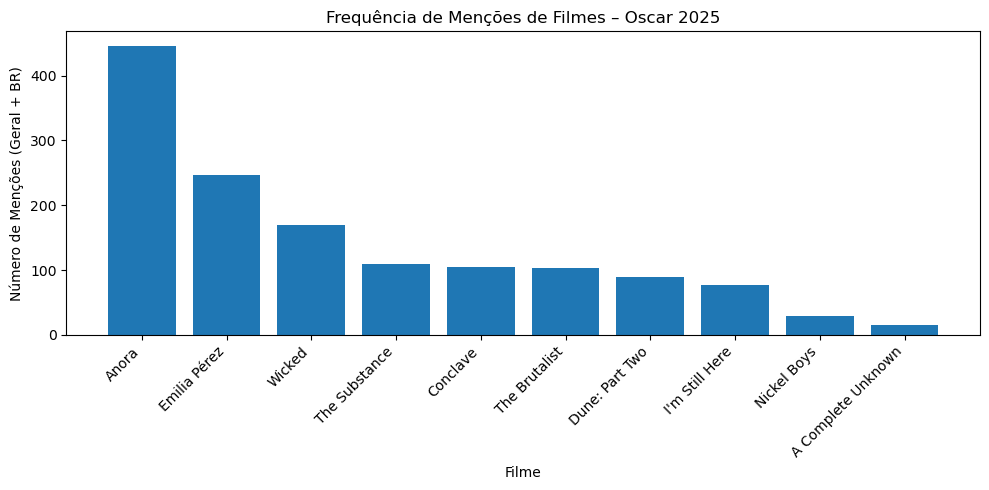

In [17]:
plt.figure(figsize=(10,5))
plt.bar(df_mentions['filme'], df_mentions['menções'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Filme')
plt.ylabel('Número de Menções (Geral + BR)')
plt.title('Frequência de Menções de Filmes – Oscar 2025')
plt.tight_layout()
plt.show()

**Análise:**

- A tabela mostra claramente o ranking de filmes mais mencionados nos comentários (dados gerais + brasileiros).
- O filme "Anora" lidera com 446 menções, seguido de "Emilia Pérez" com 247 menções e "Wicked" com 169 menções.
- No gráfico de barras, a diferença entre o 1º colocado ("Anora") e os demais é bastante visual e destacada — ele teve quase o dobro de menções que o segundo lugar.
- Outros filmes como "The Substance", "Conclave" e "The Brutalist" têm uma quantidade intermediária de menções, enquanto "Nickel Boys" e "A Complete Unknown" foram muito pouco comentados.
- A distribuição é bem desbalanceada, mostrando que poucos filmes concentram a maioria da atenção do público.

### 4.2 Qual o filme mais associado a sentimentos positivos? E a sentimentos negativos? E os neutros?

#### Passo 1: Usar apenas comentários com sentimento classificado

In [18]:
df_sentimentos = pd.concat([
    df_all[['clean_text','sentimento']],
    df_br[['clean_text','sentimento']]
], ignore_index=True)

#### Passo 2: Criar dicionários

In [19]:
filmes_norm = {
    normalize_title(f): f
    for f in filmes_oscar
}
# variantes especiais
filmes_norm['dune part 2']      = 'Dune: Part Two'
filmes_norm['dune 2']           = 'Dune: Part Two'
filmes_norm["i'm still here"]   = "I'm Still Here"
filmes_norm['im still here']    = "I'm Still Here"
filmes_norm['ainda estou aqui'] = "I'm Still Here"

# Inicia contadores
sentimentos_por_filme = {
    filme: {'positivo':0, 'neutro':0, 'negativo':0}
    for filme in filmes_oscar
}

#### Passo 3: Preencher contagens

In [20]:
for _, row in df_sentimentos.iterrows():
    txt = row['clean_text']
    sent = row['sentimento']
    for chave, titulo in filmes_norm.items():
        if chave in txt:
            sentimentos_por_filme[titulo][sent] += 1

#### Passo 4: DataFrame

In [21]:
sentimentos_df = (
    pd.DataFrame.from_dict(sentimentos_por_filme, orient='index')
      .assign(total=lambda df: df[['positivo','neutro','negativo']].sum(axis=1))
      .sort_values('total', ascending=False)
)
display(sentimentos_df)

,positivo,neutro,negativo,total
Anora,269,109,68,446
Emilia Pérez,98,93,56,247
Wicked,59,12,98,169
The Substance,54,31,25,110
Conclave,60,31,14,105
The Brutalist,59,27,17,103
Dune: Part Two,40,32,18,90
I'm Still Here,33,37,7,77
Nickel Boys,11,7,11,29
A Complete Unknown,11,5,0,16


#### Passo 5: Gráfico

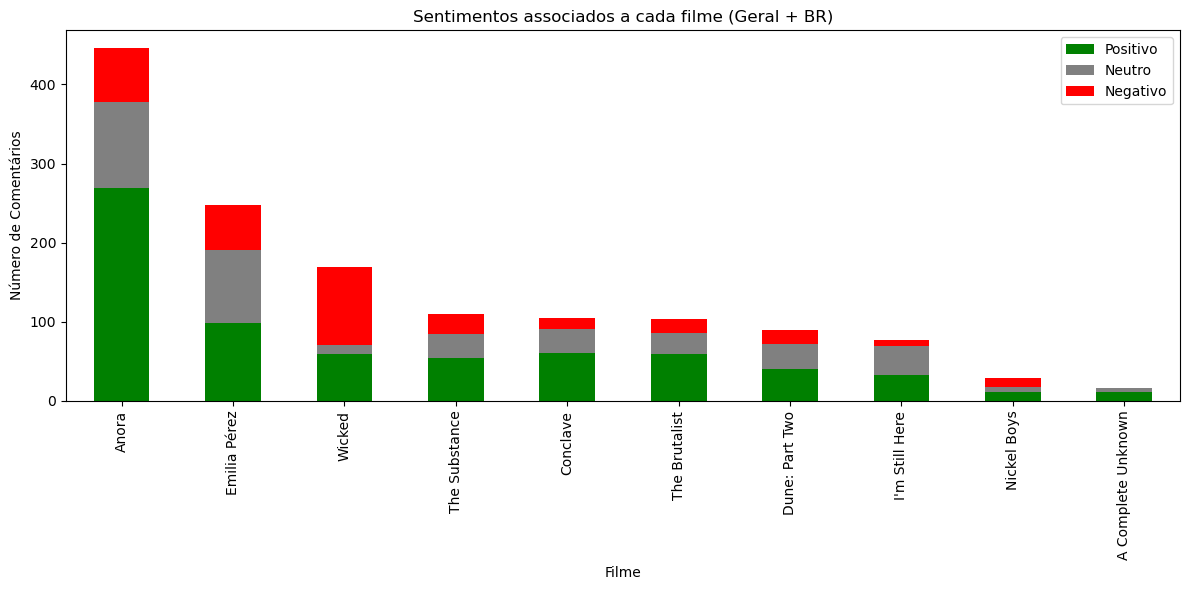

In [22]:
sentimentos_df[['positivo','neutro','negativo']].plot(
    kind='bar', stacked=True, figsize=(12,6),
    color=['green','gray','red']
)
plt.title('Sentimentos associados a cada filme (Geral + BR)')
plt.xlabel('Filme')
plt.ylabel('Número de Comentários')
plt.legend(['Positivo','Neutro','Negativo'])
plt.tight_layout()
plt.show()

**Análise:**

- "Anora" novamente se destaca, agora não só em quantidade de menções, mas também em quantidade de comentários positivos (269 positivos — mais de 60% do total).
- "Emilia Pérez" tem um perfil bem equilibrado entre positivo e neutro, mas também uma quantidade relevante de negativos.
- "Wicked" chama atenção: tem praticamente tantos comentários negativos quanto o total de positivos e neutros juntos. Isso mostra que, embora muito mencionado, o filme tem uma reação mais crítica.
- "The Substance", "Conclave" e "The Brutalist" têm perfis bem mais positivos, com poucos comentários negativos.
- "I'm Still Here" é curioso: é o filme com mais comentários neutros proporcionalmente (quase metade dos comentários são neutros), sugerindo que ele não desperta reações fortes.
- "Nickel Boys" é bem dividido: positivos e negativos estão praticamente iguais.
- "A Complete Unknown" tem poucos comentários, mas são 100% positivos ou neutros (nenhum negativo!).

    **Sobre o Gráfico:**

    - O gráfico empilhado mostra visualmente essas diferenças, e confirma tudo o que vimos acima:
    - As barras verdes (positivos) são dominantes em alguns filmes como "Anora", "The Substance" e "Conclave".
    - As barras vermelhas (negativos) são bem visíveis principalmente para "Wicked".
    - Em "I'm Still Here", a barra cinza (neutros) é maior que as outras cores.

### 4.3 Os filmes formam grupos (clusters) diferentes de acordo com o perfil de sentimentos?

#### Passo 1: Preparar as proporções de sentimentos

In [23]:
df_prop = (
    pd.DataFrame.from_dict(sentimentos_por_filme, orient='index')
      .assign(total=lambda df: df[['positivo','neutro','negativo']].sum(axis=1))
      .assign(
         p_pos=lambda df: df['positivo']/df['total'],
         p_neu=lambda df: df['neutro']/df['total'],
         p_neg=lambda df: df['negativo']/df['total']
      )
    [['p_pos','p_neu','p_neg']]
)

#### Passo 2: Agrupar (clusterizar) os filmes

In [24]:
import warnings
warnings.filterwarnings('ignore', message='.*memory leak on Windows with MKL.*')

from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, random_state=42)
df_prop['cluster'] = km.fit_predict(df_prop)

#### Passo 3: Mostrar os clusters e visualizar no gráfico

,p_pos,p_neu,p_neg,cluster
Anora,0.603139,0.244395,0.152466,0
Emilia Pérez,0.396761,0.376518,0.226721,2
Wicked,0.349112,0.071006,0.579882,1
Conclave,0.571429,0.295238,0.133333,0
Nickel Boys,0.379310,0.241379,0.379310,1
Dune: Part Two,0.444444,0.355556,0.200000,2
The Brutalist,0.572816,0.262136,0.165049,0
A Complete Unknown,0.687500,0.312500,0.000000,0
I'm Still Here,0.428571,0.480519,0.090909,2
The Substance,0.490909,0.281818,0.227273,0


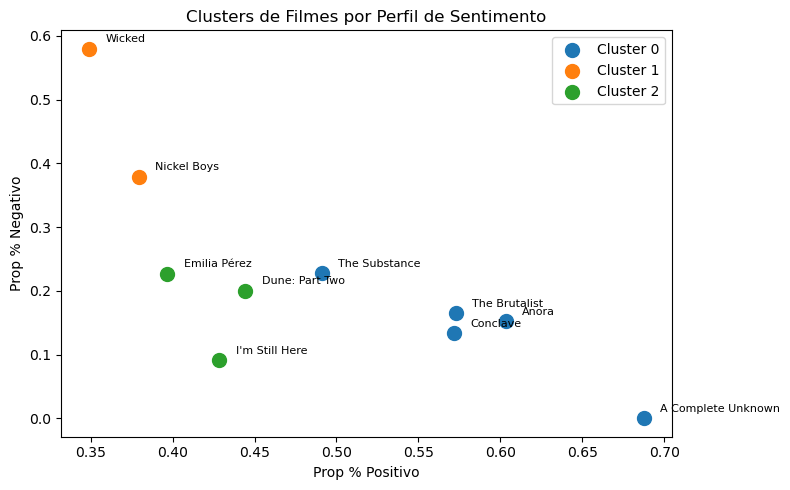

In [25]:
display(df_prop[['p_pos','p_neu','p_neg','cluster']])

fig, ax = plt.subplots(figsize=(8,5))
for c in range(k):
    sel = df_prop[df_prop['cluster']==c]
    ax.scatter(sel['p_pos'], sel['p_neg'], label=f'Cluster {c}', s=100)
    for filme in sel.index:
        ax.text(sel.loc[filme,'p_pos']+0.01, sel.loc[filme,'p_neg']+0.01, filme, fontsize=8)
ax.set_xlabel('Prop % Positivo')
ax.set_ylabel('Prop % Negativo')
ax.set_title('Clusters de Filmes por Perfil de Sentimento')
ax.legend()
plt.tight_layout()
plt.show()

**Análise detalhada:**

**Cluster 0 (Azul) — Mais Positivos:**

- Filmes: Anora, Conclave, The Brutalist, The Substance, A Complete Unknown
- Característica: Alta taxa de comentários positivos e baixa de negativos.
- "A Complete Unknown" é o que mais se destaca, com quase 70% de positivos e nenhum comentário negativo.

**Cluster 1 (Laranja) — Mais Negativos:**

- Filmes: Wicked, Nickel Boys
- Característica: Altíssima proporção de negativos.
-- "Wicked" é o caso extremo: quase 58% de negativos, e só 35% de positivos.

**Cluster 2 (Verde) — Neutros/Equilibrados:**

- Filmes: Emilia Pérez, Dune: Part Two, I'm Still Here
- Característica: Mistura de sentimentos, com grande presença de comentários neutros.
- Exemplo: I'm Still Here tem 48% neutros — quase metade dos comentários.

## 5. Conclusão

Este trabalho analisou um conjunto de 12.811 comentários em inglês e 2.498 comentários em português (Brasil) sobre os filmes indicados ao Oscar de 2025, classificando cada mensagem em positivo, neutro ou negativo. No conjunto geral, observou-se que 42,87 % dos comentários eram positivos, 35,40 % neutros e 21,73 % negativos, enquanto no recorte brasileiro predominou uma postura mais neutra (68,61 %), com apenas 20,06 % de positivos e 11,33 % de negativos. Além disso, quantificamos o volume de menções a cada filme, destacando Anora como o mais associado a comentários positivos (mais de 60 %), seguido por I'm Still Here como o mais associado a comentários neutros (quase 50 %) e Wicked como o mais associado a comentários negativos (quase 60 %). Por fim, a clusterização das proporções de sentimento revelou três perfis distintos de recepção:
1. **Cluster 0 (perfil positivo)** – filmes como A Complete Unknown e Conclave onde mais de 50 % dos comentários foram favoráveis;
2. **Cluster 1 (perfil negativo)** – títulos como Wicked e Nickel Boys com altos índices de críticas;
3. **Cluster 2 (perfil neutro)** – obras como Emilia Pérez e Dune: Part Two com maioria de comentários indiferentes.

Esses resultados são importantes porque mapeiam, de forma quantitativa e comparativa, como diferentes audiências (global vs. Brasil) percebem os indicados ao Oscar. Conhecer a distribuição de sentimentos e identificar quais filmes geram mais engajamento ou controvérsia pode orientar produtoras, distribuidores e equipes de marketing a ajustar estratégias de comunicação e posicionamento para maximizar recepção e alcance.

Contudo, o estudo possui algumas limitações. Em primeiro lugar, os comentários foram coletados somente de plataformas selecionadas (e em determinados períodos), não refletindo outras redes ou contextos culturais. Além disso, A classificação de sentimento baseou-se em uma ferramenta genérica de análise de sentimento, que pode ter dificuldades com ironias, gírias ou interjeições específicas. Finalmente, a clusterização considerou apenas proporções globais de sentimento, sem levar em conta variáveis temporais ou demográficas.

**Para trabalhos futuros, pode-se fazer:**

- Expandir a coleta para múltiplas plataformas (Twitter, Reddit, Instagram) e realizar análises temporais para capturar tendências antes e depois das premiações.

- Aprimorar o pré-processamento e usar modelos de linguagem mais avançados (transformers ou embeddings contextualizados) para melhorar a acurácia da classificação de sentimento.

- Incorporar técnicas de topic modeling ou análise de opinião para entender quais aspectos dos filmes (trama, atuação, direção) mais influenciam o sentimento do público.

- Utilizar métricas de relevância dos comentários (upvotes e depth) como pesos na análise, de modo a dar maior ênfase àqueles trechos de maior impacto e visibilidade nas discussões.